In [45]:
import numpy as np 
import pandas as pd 
import os

import warnings
warnings.filterwarnings("ignore")

1. Закачиваю тест и вал каждой модели
2. Составляю ДФ трэйн и ДФ тест
3. Тренирую модель
4. Получаю предсказания
5. Сохраняю предсказания

# Loading

In [2]:
sub = pd.read_csv('sample_submission.csv')

In [3]:
valid_labels = pd.read_csv('valid_labels.csv').to_numpy()

In [24]:
pred_val_EffNetB7 = pd.read_csv('preds_EffNetB7_val.csv')
pred_test_EffNetB7 = pd.read_csv('preds_EffNetB7_test.csv')

In [25]:
pred_val_IncV3 = pd.read_csv('preds_IncV3_val.csv')
pred_test_IncV3 = pd.read_csv('preds_IncV3_test.csv')

In [26]:
pred_val_Xcept = pd.read_csv('preds_Xcept_val.csv')
pred_test_Xcept = pd.read_csv('preds_Xcept_test.csv')

In [8]:
pred_train = np.concatenate((pred_val_EffNetB7, pred_val_IncV3, pred_val_Xcept), axis=1)
pred_train.shape

(274, 12)

In [11]:
pred_test = np.concatenate((pred_test_EffNetB7.loc[:, 'healthy':], pred_test_IncV3.loc[:, 'healthy':], pred_test_Xcept.loc[:, 'healthy':]), axis=1)
pred_test.shape

(1821, 12)

# MLPClassifier LB 0.925

In [15]:
from sklearn.neural_network import MLPClassifier

MLP_clf = MLPClassifier(max_iter=400)
MLP_clf.fit(pred_train, valid_labels)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [16]:
predictionMLP = MLP_clf.predict(pred_test)

In [18]:
sub.loc[:, 'healthy':] = predictionMLP
sub.to_csv('submission_3models_MLP_Clf.csv', index=False)
sub.head()
# LB 0.961, clf 0.925

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0,0,1,0
1,Test_1,0,0,1,0
2,Test_2,0,0,0,1
3,Test_3,1,0,0,0
4,Test_4,0,0,1,0


# Ridge LB 0.962

In [20]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1, random_state=241)
ridge.fit(pred_train, Y)
predictions = ridge.predict(pred_test)

In [21]:
sub.loc[:, 'healthy':] = predictions
sub.to_csv('submission_predict_ridge.csv', index=False)
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.000872,0.006601,0.991457,0.001070
1,Test_1,0.000871,0.006620,0.991437,0.001072
2,Test_2,-0.005331,0.005607,0.000326,0.999398
3,Test_3,0.994449,0.012190,-0.002802,-0.003837
4,Test_4,0.000872,0.007434,0.990644,0.001050


# Entropies LB 0.970

1. 5 моделей энтропия
2. 5 моделей среднее
3. 3 модели энтропия

In [61]:
sub1 = pd.read_csv('preds_EffNetB7_test.csv')
sub2 = pd.read_csv('preds_IncV3_test.csv')
sub3 = pd.read_csv('preds_DenseNet201_test.csv')
# sub4 = pd.read_csv('preds_ResNet152V2_test.csv')
# sub5 = pd.read_csv('preds_Xcept_test.csv')
sub = pd.read_csv('sample_submission.csv')

In [ ]:
from scipy.stats import entropy

In [62]:
ent1 = entropy(sub1.loc[:,'healthy' : ], base=2, axis = 1)
ent2 = entropy(sub2.loc[:,'healthy' : ], base=2, axis = 1)
ent3 = entropy(sub3.loc[:,'healthy' : ], base=2, axis = 1)
# ent4 = entropy(sub4.loc[:,'healthy' : ], base=2, axis = 1)
# ent5 = entropy(sub5.loc[:,'healthy' : ], base=2, axis = 1)
entropies = np.array([ent1, ent2, ent3]).transpose()
entropies.shape

selected = np.argmin(entropies, axis = 1)

In [63]:
submission_size = len(selected)
for i in range(submission_size):
    if selected[i] ==0:
        sub.loc[i, 'healthy' : ] = sub1.loc[i, 'healthy' :]
    elif selected[i] ==1:
        sub.loc[i, 'healthy' : ] = sub2.loc[i, 'healthy' :]
    elif selected[i] == 2:
        sub.loc[i, 'healthy' : ] = sub3.loc[i, 'healthy' :]
#     elif selected[i] == 3:
#         sub.loc[i, 'healthy' : ] = sub4.loc[i, 'healthy' :]
#     elif selected[i] == 4:
#         sub.loc[i, 'healthy' : ] = sub5.loc[i, 'healthy' :]

In [64]:
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,3.226034e-05,3.505256e-05,9.999325e-01,1.039862e-07
1,Test_1,1.153907e-09,1.142887e-06,9.999987e-01,8.203622e-08
2,Test_2,7.117664e-10,3.494383e-08,9.916015e-12,1.000000e+00
3,Test_3,1.000000e+00,1.876774e-11,4.333987e-08,4.859804e-08
4,Test_4,7.352387e-06,4.908777e-04,9.995005e-01,1.230405e-06


In [65]:
sub.to_csv('submission_Entropy_EffNetB7_IncV3_DenseNet201.csv', index=False)
#sub.to_csv('submission_Entropy_5_models.csv', index=False)

In [60]:
sub = pd.read_csv('sample_submission.csv')
preds_avg = (sub1.loc[:, 'healthy' :] + sub2.loc[:, 'healthy' :] + sub3.loc[:, 'healthy' :] + sub4.loc[:, 'healthy' :] + sub5.loc[:, 'healthy' :]) / 5
sub.loc[:, 'healthy':] = preds_avg
#sub.to_csv('submission_Avg_EffNetB7_IncV3_DenseNet201.csv', index=False)
sub.to_csv('submission_Avg_5_models.csv', index=False)
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,7.729043e-06,4.265106e-03,9.957258e-01,0.000001
1,Test_1,5.375072e-05,2.229967e-03,9.976207e-01,0.000096
2,Test_2,1.505363e-07,7.449557e-07,9.929590e-08,0.999999
3,Test_3,9.997867e-01,1.290470e-06,1.814960e-04,0.000031
4,Test_4,2.621242e-05,3.380577e-03,9.963644e-01,0.000229


# Stacking keras LB 0.946

1. Обучаю 5 моделей с использованием кросс-валидации. 
2. Для каждой модели рассчитываю prediction для обучаемой выборки, сохраняю. И для тестовой, сохраняю
3. Строю НН с кросс-валидацией, где prediction по 5 моделям - это train, а labels это Y
4. По CV оцениваю эту модель
5. Получаю предсказания по метамодели для предсказаний для тестовой выборки


In [49]:
import numpy as np 
import pandas as pd 
import os

In [122]:
sub = pd.read_csv('sample_submission.csv')

sub_train_1 = pd.read_csv('preds_EffNetB7_train.csv')
sub_train_2 = pd.read_csv('preds_IncV3_train.csv')
sub_train_3 = pd.read_csv('preds_DenseNet201_train.csv')
sub_train_4 = pd.read_csv('preds_ResNet152V2_train.csv')
sub_train_5 = pd.read_csv('preds_Xcept_train.csv')

train_labels = pd.read_csv('train_labels.csv').to_numpy()

sub_val_1 = pd.read_csv('preds_EffNetB7_val.csv')
sub_val_2 = pd.read_csv('preds_IncV3_val.csv')
sub_val_3 = pd.read_csv('preds_DenseNet201_val.csv')
sub_val_4 = pd.read_csv('preds_ResNet152V2_val.csv')
sub_val_5 = pd.read_csv('preds_Xcept_val.csv')

valid_labels = pd.read_csv('valid_labels.csv').to_numpy()

sub_test_1 = pd.read_csv('preds_EffNetB7_test.csv')
sub_test_2 = pd.read_csv('preds_IncV3_test.csv')
sub_test_3 = pd.read_csv('preds_DenseNet201_test.csv')
sub_test_4 = pd.read_csv('preds_ResNet152V2_test.csv')
sub_test_5 = pd.read_csv('preds_Xcept_test.csv')

In [51]:
pred_train = np.column_stack((sub_train_1.loc[:, 'healthy':], 
                            sub_train_2.loc[:, 'healthy':], 
                            sub_train_3.loc[:, 'healthy':], 
                            sub_train_4.loc[:, 'healthy':], 
                            sub_train_5.loc[:, 'healthy':]
                            ))
pred_train.shape

(1547, 20)

In [52]:
pred_val = np.column_stack((sub_val_1.loc[:, 'healthy':], 
                            sub_val_2.loc[:, 'healthy':], 
                            sub_val_3.loc[:, 'healthy':],
                            sub_val_4.loc[:, 'healthy':], 
                            sub_val_5.loc[:, 'healthy':]
                          ))
pred_val.shape

(274, 20)

In [53]:
pred_test = np.column_stack((sub_test_1.loc[:, 'healthy':], 
                            sub_test_2.loc[:, 'healthy':], 
                            sub_test_3.loc[:, 'healthy':],
                            sub_test_4.loc[:, 'healthy':], 
                            sub_test_5.loc[:, 'healthy':]
                           ))
pred_test.shape

(1821, 20)

In [54]:
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")

In [89]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
layers.Dense(128, activation='sigmoid', input_shape=(20,)),
layers.Dropout(0.5),
layers.Dense(64, activation='sigmoid'),
layers.Dropout(0.5),
layers.Dense(4, activation='sigmoid')])

model.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy'])

In [90]:
history = model.fit(pred_train, train_labels, epochs=100, batch_size=16,
          validation_data=(pred_val, valid_labels))

Train on 1547 samples, validate on 274 samples
Epoch 1/100
1547/1547 [==============================] - 1s 450us/sample - loss: 1.2711 - categorical_accuracy: 0.3652 - val_loss: 1.1546 - val_categorical_accuracy: 0.6533
Epoch 2/100
1547/1547 [==============================] - 0s 142us/sample - loss: 1.0393 - categorical_accuracy: 0.6464 - val_loss: 0.6919 - val_categorical_accuracy: 0.9489
Epoch 3/100
1547/1547 [==============================] - 0s 142us/sample - loss: 0.5225 - categorical_accuracy: 0.9095 - val_loss: 0.2439 - val_categorical_accuracy: 0.9489
Epoch 4/100
1547/1547 [==============================] - 0s 143us/sample - loss: 0.2399 - categorical_accuracy: 0.9580 - val_loss: 0.1675 - val_categorical_accuracy: 0.9599
Epoch 5/100
1547/1547 [==============================] - 0s 137us/sample - loss: 0.1426 - categorical_accuracy: 0.9761 - val_loss: 0.1476 - val_categorical_accuracy: 0.9562
Epoch 6/100
1547/1547 [==============================] - 0s 146us/sample - loss: 0.0948 

Epoch 48/100
1547/1547 [==============================] - 0s 133us/sample - loss: 0.0025 - categorical_accuracy: 1.0000 - val_loss: 0.2925 - val_categorical_accuracy: 0.9635
Epoch 49/100
1547/1547 [==============================] - 0s 134us/sample - loss: 0.0045 - categorical_accuracy: 0.9994 - val_loss: 0.2954 - val_categorical_accuracy: 0.9635
Epoch 50/100
1547/1547 [==============================] - 0s 133us/sample - loss: 0.0027 - categorical_accuracy: 0.9994 - val_loss: 0.3022 - val_categorical_accuracy: 0.9672
Epoch 51/100
1547/1547 [==============================] - 0s 133us/sample - loss: 0.0034 - categorical_accuracy: 0.9994 - val_loss: 0.3056 - val_categorical_accuracy: 0.9672
Epoch 52/100
1547/1547 [==============================] - 0s 132us/sample - loss: 0.0023 - categorical_accuracy: 1.0000 - val_loss: 0.3095 - val_categorical_accuracy: 0.9672
Epoch 53/100
1547/1547 [==============================] - 0s 130us/sample - loss: 0.0020 - categorical_accuracy: 1.0000 - val_loss

1547/1547 [==============================] - 0s 139us/sample - loss: 0.0016 - categorical_accuracy: 0.9994 - val_loss: 0.3585 - val_categorical_accuracy: 0.9635
Epoch 96/100
1547/1547 [==============================] - 0s 136us/sample - loss: 0.0032 - categorical_accuracy: 0.9987 - val_loss: 0.3599 - val_categorical_accuracy: 0.9635
Epoch 97/100
1547/1547 [==============================] - 0s 141us/sample - loss: 0.0010 - categorical_accuracy: 1.0000 - val_loss: 0.3603 - val_categorical_accuracy: 0.9635
Epoch 98/100
1547/1547 [==============================] - 0s 135us/sample - loss: 0.0059 - categorical_accuracy: 0.9994 - val_loss: 0.3709 - val_categorical_accuracy: 0.9708
Epoch 99/100
1547/1547 [==============================] - 0s 130us/sample - loss: 8.9535e-04 - categorical_accuracy: 1.0000 - val_loss: 0.3740 - val_categorical_accuracy: 0.9672
Epoch 100/100
1547/1547 [==============================] - 0s 136us/sample - loss: 8.7763e-04 - categorical_accuracy: 1.0000 - val_loss: 0.

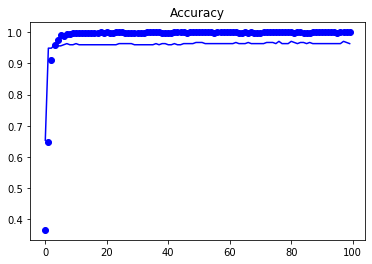

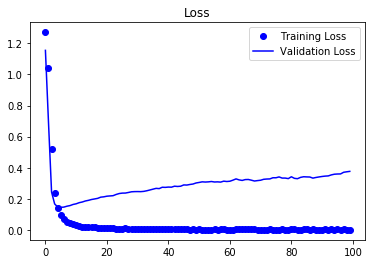

In [91]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
loss = history.history['loss']
val_acc = history.history['val_categorical_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [35]:
result = model.predict(pred_test, batch_size=32)

In [37]:
sub.loc[:, 'healthy':] = result
sub.to_csv('submission_3_models_Keras.csv', index=False)
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,3.879749e-22,4.918325e-15,1.000000e+00,1.096902e-10
1,Test_1,2.051398e-22,2.942911e-15,1.000000e+00,7.882055e-11
2,Test_2,1.704637e-22,2.062687e-17,1.859081e-24,1.000000e+00
3,Test_3,1.000000e+00,1.252661e-14,1.276729e-21,1.410454e-09
4,Test_4,2.371082e-22,3.293428e-15,1.000000e+00,8.557685e-11


# AdaBoost LB 0.904

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

clf = AdaBoostClassifier(n_estimators=100)

In [109]:
model = clf.fit(pred_train, train_labels[:, 0])
result0 = model.predict(pred_test)

scores = cross_val_score(clf, pred_train, train_labels[:, 0], cv=5)
print('scores mean: ', scores.mean())

result_val = model.predict(pred_val)
print('accuracy_score: ', metrics.accuracy_score(valid_labels[:, 0], result_val))

scores mean:  1.0
accuracy_score:  0.9963503649635036


In [105]:
model = clf.fit(pred_train, train_labels[:, 1])
result1 = model.predict(pred_test)

scores = cross_val_score(clf, pred_train, train_labels[:, 1], cv=5)
print('scores mean: ', scores.mean())

result_val = model.predict(pred_val)
print('accuracy_score: ', metrics.accuracy_score(valid_labels[:, 1], result_val))

scores mean:  0.9993548387096775
accuracy_score:  0.9708029197080292


In [106]:
model = clf.fit(pred_train, train_labels[:, 2])
result2 = model.predict(pred_test)

scores = cross_val_score(clf, pred_train, train_labels[:, 2], cv=5)
print('scores mean: ', scores.mean())

result_val = model.predict(pred_val)
print('accuracy_score: ', metrics.accuracy_score(valid_labels[:, 2], result_val))

scores mean:  1.0
accuracy_score:  0.9890510948905109


In [107]:
model = clf.fit(pred_train, train_labels[:, 3])
result3 = model.predict(pred_test)

scores = cross_val_score(clf, pred_train, train_labels[:, 3], cv=5)
print('scores mean: ', scores.mean())

result_val = model.predict(pred_val)
print('accuracy_score: ', metrics.accuracy_score(valid_labels[:, 3], result_val))

scores mean:  0.998705501618123
accuracy_score:  0.9854014598540146


In [111]:
result = np.column_stack((result0, 
                            result1, 
                            result2,
                            result3
                          ))
result.shape

(1821, 4)

In [112]:
sub.loc[:, 'healthy':] = result
sub.to_csv('submission_5_models_AdaBoost.csv', index=False)
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0,0,1,0
1,Test_1,0,0,1,0
2,Test_2,0,0,0,1
3,Test_3,1,0,0,0
4,Test_4,0,0,1,0


# Stacking Linear regression LB 0.906

In [136]:
from sklearn.linear_model import LinearRegression

In [137]:
meta_model = LinearRegression()
meta_model.fit(pred_train, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [138]:
scores = cross_val_score(meta_model, pred_train, train_labels, cv=5)
print('scores mean: ', scores.mean())

scores mean:  0.9986170600688598


In [139]:
result = meta_model.predict(pred_test)

In [140]:
sub.loc[:, 'healthy':] = result
sub.to_csv('submission_5_models_LinearRegression.csv', index=False)
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,-0.000316,0.005636,0.999458,-0.004778
1,Test_1,-0.000353,0.001480,0.999478,-0.000605
2,Test_2,-0.000036,-0.000537,-0.000003,1.000576
3,Test_3,1.000027,-0.000151,-0.000049,0.000172
4,Test_4,-0.000042,0.000536,0.999934,-0.000428
